Consider the glass fragments data from the book's website.
Let $Y$ be the refractive index and let $X$ be the alumninum content
(the fourth variable).
1. Do a nonparametric regression to fit the model
   $Y = f(x) + \varepsilon$ using the cosine basis method.
   The data are not on a regular grid.
   Ignore this when estimating the function.
   (But do sort the data first according to $X$.)
   Provide a function estimate, an estimate of the risk, and a confidence band.
1. Use the wavelet method to estimate $f$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

### Download the glass fragment data

In [2]:
# Read the data into a pandas data frame
df = pd.read_csv('../data/glass_clean.dat', sep='\t')

# Transform the two dataframe columns of interest into an array
# where the first column corresponds to X,
# the second column corresponds to Y, and
# each row corresponds to a sample.
glass_X = df['Al'].to_numpy()
glass_Y = df['RI'].to_numpy()

### Define all the helper functions

In [3]:
def cosine_synthesis(coefficients, x_arr):
    """
    Reconstructs a function based on its cosine basis
    coefficients, ordered from j=0 to n, then
    evaluates that function at the x-values in x_arr.
    """

    j_mesh, x_mesh = np.meshgrid(range(1, len(coefficients)), x_arr, indexing='ij')
    coeff_mesh = coefficients[j_mesh]
    y_arr = coefficients[0] + np.sqrt(2)*np.sum(
        coeff_mesh*np.cos(np.pi*j_mesh*x_mesh),
        axis = 0
    )

    return y_arr

def cosine_coefficients_from_data(Y, X, J):
    """
    Given samples (Y_1, X_1), ... (Y_n, X_n)
    stored in two 1D arrays Y and X, return
    estimates of the cosine basis coefficients
    of the regression function r(x) = E(Y|X=x),
    up to j=J.

    IMPORTANT: The data is normalized so that
    0 < X < 1, and so the regression function
    produced is defined on [0, 1].
    """

    X_norm = (X - X.min())/(X.max() - X.min())

    # We compute the 2D array Yi cos(j*pi*xi),
    # indexed by (i, j)
    regression_basis_coefficient_sample = np.einsum(
        'i, ij -> ij',
        Y,
        np.cos(np.pi*np.outer(
            X_norm,
            range(J + 1)
        ))
    )

    # The estimate \hat beta_j is the sample mean
    # of Yi cos(j*pi*xi), which we then multiply
    # by sqrt(2), except when j=0 where we multiply by one.
    regression_basis_coefficient = (
        np.concatenate(([1], np.sqrt(2)*np.ones(J)))
        *np.mean(regression_basis_coefficient_sample, axis=0)
    )

    return regression_basis_coefficient

def plot_cosine_regression_from_data(Y, X, J, x_arr, show_scatter_plot=True):
    """
    Given samples (Y_1, X_1), ... (Y_n, X_n)
    stored in two 1D arrays Y and X, plot
    the cosine basis regression estimator
    along the x-values in x_arr.
    
    Arguments:
    Y       1D array of response samples.
    X       1D array of covariate samples.
    J       Smoothing parameter (truncate
            the cosine expansion at j = J).
    x_arr   1D array of x-values at which to evalute
            the regression function estimate.
    """

    coefficients = cosine_coefficients_from_data(Y, X, J)
    y_arr = cosine_synthesis(coefficients, x_arr)
    x_arr_scaled = (X.max() - X.min())*x_arr + X.min()

    plt.plot(x_arr_scaled, y_arr, color='crimson')
    if show_scatter_plot:
        plt.scatter(X, Y, color='darkseagreen', alpha=0.3)

def variance_estimate(Y, X):
    """
    Given samples (Y_1, X_1), ... (Y_n, X_n)
    stored in two 1D arrays Y and X, estimate
    the variance of Y - r(X), where r denotes
    the regression function r(x) = E(Y|X=x).

    Empirical observation:
    this *largely* overestimates the variance
    when that variance is small, but seems
    accurate otherwise.
    """

    # Number of samples
    n = len(Y)

    # Number of final modes to consider
    k = int(np.floor(n/4))

    # Compute the estimates of the cosine basis coefficients
    # of the regression function
    coefficients = cosine_coefficients_from_data(Y, X, n)
    
    return (n/k)*np.sum(coefficients[-k:]**2)

def smoothing_parameter_from_risk_estimate(Y, X):
    """
    Given samples (Y_1, X_1), ... (Y_n, X_n)
    stored in two 1D arrays Y and X, compute
    the risk estimate for J = 0, ..., n, then
    return the value of J that minimizes it.
    """
    
    n = len(Y)
    coefficients = cosine_coefficients_from_data(Y, X, n)
    sigma_square = variance_estimate(Y, X)
    
    bias_estimate_j = coefficients**2 - sigma_square/n
    bias_estimate_j = np.where(bias_estimate_j > 0, bias_estimate_j, 0)
    bias_estimate_partial_sums = np.flip(np.flip(bias_estimate_j).cumsum())
    
    risk_estimate = np.arange(n + 1)*sigma_square/n + bias_estimate_partial_sums
    return np.argmin(risk_estimate)

def plot_confidence_band(Y, X, x_arr, alpha=0.05):
    """
    Given samples (Y_1, X_1), ... (Y_n, X_n)
    stored in two 1D arrays Y and X, and
    a value alpha in (0, 1), plot a 1 - alpha
    confidence band for the cosine basis
    regression estimator.
    """

    # Number of samples
    n = len(Y)
    
    # Determine the optimal smoothing parameter
    # from the risk estimate
    optimal_J = smoothing_parameter_from_risk_estimate(Y, X)

    # Compute the auxiliary functions used
    # to construct the confidence band
    a_tilde = 1 + (2*optimal_J - 1 + np.sin((2*optimal_J + 1)*np.pi*x_arr))/2
    alpha_quantile = stats.chi2.isf(alpha, df=optimal_J)
    
    sigma_square = variance_estimate(Y, X)
    confidence = np.sqrt((sigma_square*alpha_quantile/n)*a_tilde)
    
    # Array used for plotting
    x_arr_scaled = (X.max() - X.min())*x_arr + X.min()
    
    # Confidence band
    coefficients = cosine_coefficients_from_data(Y, X, optimal_J)
    y_arr = cosine_synthesis(coefficients[:optimal_J + 1], x_arr)
    plt.fill_between(x_arr_scaled, y_arr - confidence, y_arr + confidence, color='lightsteelblue')

### Plot the cosine basis regression estimator for the glass fragment data
Currently the value of the smoothing parameter $J$ is fixed ahead of time
(and not chosen by minimizing the estimated risk).

Note that we do *not* expect the cosine basis or Haar wavelet
regression estimators to perform particularly well
since the distribution of the covariate $X$ is **not** uniform,
as evidenced by the crude histogram below.

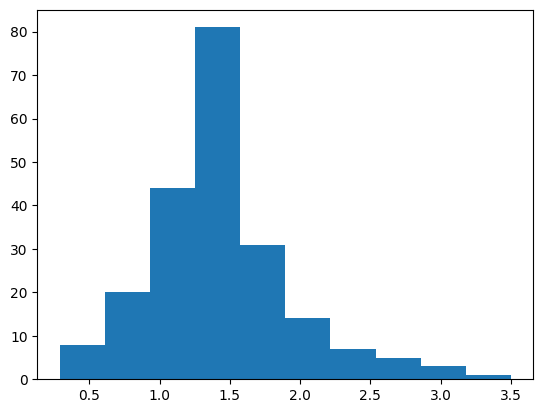

In [4]:
plt.hist(glass_X)
plt.show()
plt.close()

In [16]:
optimal_J = smoothing_parameter_from_risk_estimate(glass_Y, glass_X)
print(f"Optimal smoothing parameter: {optimal_J}")

Optimal smoothing parameter: 7


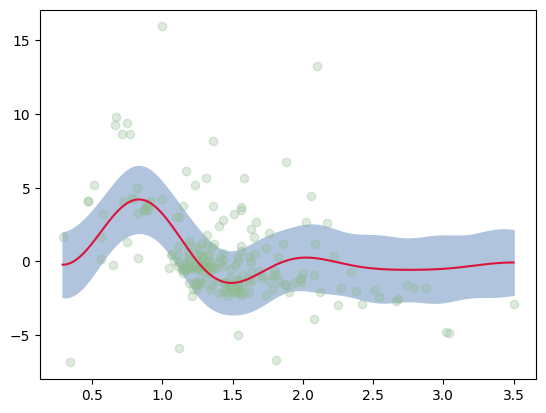

In [17]:
x_arr = np.linspace(0, 1, 1000)
plot_confidence_band(glass_Y, glass_X, x_arr)
plot_cosine_regression_from_data(glass_Y, glass_X, optimal_J, x_arr)
plt.show()
plt.close()

### Plot the cosine basis regression estimator for synthetic data

In [9]:
# Generate synthetic data
n = 1000
true_regression_function = lambda x: np.cos(2*np.pi*x)**3

synthetic_X = stats.uniform.rvs(scale=1, size=n)
error = stats.norm.rvs(scale=1, size=n)
synthetic_Y = true_regression_function(synthetic_X) + error

optimal_J = smoothing_parameter_from_risk_estimate(synthetic_Y, synthetic_X)
print(f"Optimal smoothing parameter: {optimal_J}")

Optimal smoothing parameter: 7


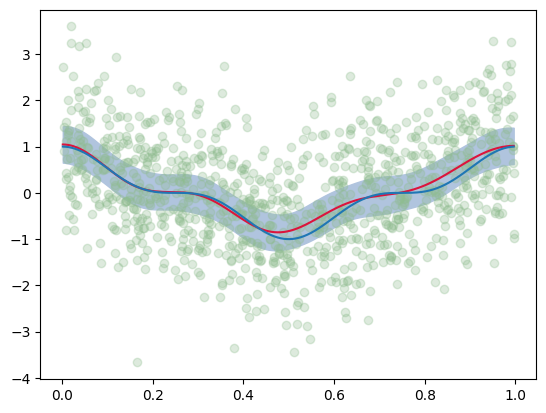

Estimate of the variance: 1.455


In [10]:
# Plot the cosine basis regression estimator, the data,
# and the true regression function
J = optimal_J
x_arr = np.linspace(0, 1, 1000)
plot_confidence_band(synthetic_Y, synthetic_X, x_arr)
plot_cosine_regression_from_data(synthetic_Y, synthetic_X, J, x_arr)
x_arr_scaled = (synthetic_X.max() - synthetic_X.min())*x_arr + synthetic_X.min()
plt.plot(x_arr_scaled, true_regression_function(x_arr_scaled))
plt.show()
plt.close()

# Estimate the variance 
print(f"Estimate of the variance: {variance_estimate(synthetic_Y, synthetic_X):.3f}")

Verify the computation of the basis coefficients estimates
by comparing them the notebook from Exercise 06.

In [11]:
empirical_coefficients = cosine_coefficients_from_data(synthetic_Y, synthetic_X, J=10)
for j, coeff in enumerate(empirical_coefficients):
    print(f"beta {j:2}: {coeff:6.3f}")
print("\nWe expect\nbeta_2 = 0.5303 and\nbeta_6 = 0.1768,\notherwise beta_j = 0.")

beta  0:  0.056
beta  1: -0.040
beta  2:  0.523
beta  3:  0.015
beta  4:  0.032
beta  5: -0.013
beta  6:  0.135
beta  7:  0.048
beta  8:  0.011
beta  9: -0.004
beta 10:  0.011

We expect
beta_2 = 0.5303 and
beta_6 = 0.1768,
otherwise beta_j = 0.


We verify that everything still works (at least, passes the eye test)
even when the $X_i$'s do not lie in [0, 1].

In [12]:
# Generate synthetic data
n = 1000
true_regression_function = lambda x: np.cos(2*np.pi*x)**3

synthetic_X = stats.uniform.rvs(loc=-1, scale=3, size=n)
error = stats.norm.rvs(scale=2, size=n)
synthetic_Y = true_regression_function(synthetic_X) + error

optimal_J = smoothing_parameter_from_risk_estimate(synthetic_Y, synthetic_X)
print(f"Optimal smoothing parameter: {optimal_J}")

Optimal smoothing parameter: 7


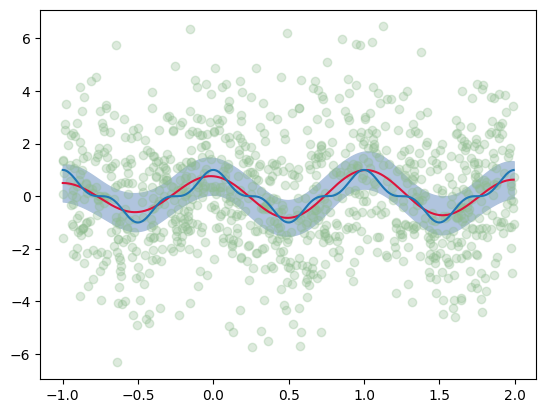

Estimate of the variance: 4.668


In [13]:
# Plot the cosine basis regression estimator, the data,
# and the true regression function
J = optimal_J
x_arr = np.linspace(0, 1, 1000)
plot_confidence_band(synthetic_Y, synthetic_X, x_arr)
plot_cosine_regression_from_data(synthetic_Y, synthetic_X, J, x_arr)
x_arr_scaled = (synthetic_X.max() - synthetic_X.min())*x_arr + synthetic_X.min()
plt.plot(x_arr_scaled, true_regression_function(x_arr_scaled))
plt.show()
plt.close()

# Estimate the variance 
print(f"Estimate of the variance: {variance_estimate(synthetic_Y, synthetic_X):.3f}")

We verify that everything still works (at least, passes the eye test)
even when the $X_i$'s do not lie in [0, 1]
**and** the true regression function is *not* periodic.

In [37]:
# Generate synthetic data
n = 500
true_regression_function = lambda x: x**2

synthetic_X = stats.uniform.rvs(loc=-2, scale=6, size=n)
error = stats.norm.rvs(scale=1, size=n)
synthetic_Y = true_regression_function(synthetic_X) + error

optimal_J = smoothing_parameter_from_risk_estimate(synthetic_Y, synthetic_X)
print(f"Optimal smoothing parameter: {optimal_J}")

Optimal smoothing parameter: 5


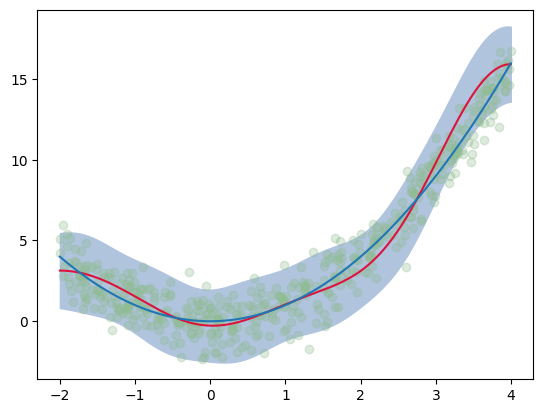

Estimate of the variance: 44.227


In [38]:
# Plot the cosine basis regression estimator, the data,
# and the true regression function
J = optimal_J
x_arr = np.linspace(0, 1, 1000)
plot_confidence_band(synthetic_Y, synthetic_X, x_arr)
plot_cosine_regression_from_data(synthetic_Y, synthetic_X, J, x_arr)
x_arr_scaled = (synthetic_X.max() - synthetic_X.min())*x_arr + synthetic_X.min()
plt.plot(x_arr_scaled, true_regression_function(x_arr_scaled))
plt.show()
plt.close()

# Estimate the variance 
print(f"Estimate of the variance: {variance_estimate(synthetic_Y, synthetic_X):.3f}")